In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import floor, ceil

In [2]:
class Visualize_adc(object):
    def __init__(self):
        pass
    def plot(self, signals, title):
        t_analog = signals[0]
        analog_signal = signals[1]
        analog_signal_for_adc = signals[7]
        t_digital = signals[2]
        t_digital_shift = signals[6]
        digital_signal = signals[3]
        digital_sampling_rate = signals[4]
        adc = signals[5]

        fig, ax1 = plt.subplots()
        ax1.set_ylabel('Voltage', color='b')
        ax1.tick_params('y', colors='b')
        l1, = ax1.plot(t_analog, analog_signal,'-b', zorder=10)
        ax1.plot(t_digital[1:], analog_signal_for_adc, 'ro')
        ax1.set_xlabel('Time')
        #ax1.set_ylim([adc.lower_ref_voltage, adc.upper_ref_voltage])
        
        ax2 = ax1.twinx()
        #ax2.set_ylim([0, 2**adc.resolution-1])
        l2, = ax2.step(t_digital+t_digital_shift, digital_signal, 'r', zorder=10)
        ax2.plot(t_digital[1:], digital_signal[1:], '*g', zorder=10)
        ax2.set_ylabel('ADC Output', color='r')
        ax2.tick_params('y', colors='r')
        plt.legend(handles=[l1, l2], labels=['Input Signal', 'Quantized Signal'], frameon=False)
        plt.tight_layout()
        plt.grid(linestyle='--')
        plt.title(title)
        plt.show()

class System(object):
    # This class create signals and do the ADC
    def __init__(self, analog_sampling_rate, digital_sampling_rate, adc):
        self.analog_sampling_rate = analog_sampling_rate
        self.adc = adc
        self.digital_sampling_rate = digital_sampling_rate
    def get_signal(self, analog_signal):
        t_analog = np.linspace(0, 1, self.analog_sampling_rate)
        under_sampling_step = int(np.ceil(self.analog_sampling_rate/self.digital_sampling_rate))
        
        analog_signal_for_adc = analog_signal[1::under_sampling_step]
        digital_signal = self.adc.get_val(analog_signal_for_adc.copy())
        #digital_signal = self.adc.get_val(analog_signal.copy())
        digital_signal = np.concatenate((digital_signal[0:1], digital_signal))
        t_digital_shift = (t_analog[under_sampling_step+1]-t_analog[1])/2        
        t_digital = t_analog[1::under_sampling_step]
        t_digital = np.concatenate((t_digital[0:1]-t_digital_shift, t_digital))

        return [t_analog, analog_signal, t_digital, digital_signal, self.digital_sampling_rate, self.adc, t_digital_shift, analog_signal_for_adc]
    
# 估算 SAR ADC 的面积和功耗
def estimate_area(resolution):
    # 简化的面积估算方法，可以根据具体情况进一步优化
    area = resolution * 10  # 假设每个比较器的面积为 10
    return area

def estimate_power(resolution):
    # 简化的功耗估算方法，可以根据具体情况进一步优化
    power = resolution * 0.1  # 假设每个逻辑单元的功耗为 0.1 单位
    return power

# SAR ADC

In [17]:
class SAR:
    def __init__(self, resolution, ncomp, temp, lower_ref_voltage, upper_ref_voltage, addmismatch=False, mismatch=0.01):
        self.ncomp = ncomp
        self.resolution = resolution
        self.temperature = temp
        self.lower_ref_voltage = lower_ref_voltage
        self.upper_ref_voltage = upper_ref_voltage
        
        print("Simulating a {} bit SAR ADC".format(resolution))
        
        if addmismatch:
            print("Adding capacitor mismatch")
            self.mismatch = mismatch # default 1% mismatch for unit cap
        else:
            print("Capacitor mismatch not included")
            self.mismatch = 0
        
        # create CDAC
        self.cdac = self.dac()
        
    def comp(self, compin):
        # note that comparator output suffers from noise of comp and dac (add temperature)
        comptemp = compin + np.random.randn(compin.shape[0])*self.ncomp - abs(np.random.randn(compin.shape[0])*(0.01 * self.temperature))
        
        # comp function in vectors
        out = np.maximum(comptemp, self.lower_ref_voltage)
        out = np.minimum(out, self.upper_ref_voltage)
        return out
    
    def dac(self):
        cdac = np.zeros((self.resolution, 1))
        for i in range(self.resolution):
            cdac[i] = 2**(self.resolution-i-1)
            # add mismatch 
            mis = self.mismatch/np.sqrt(cdac[i])
            cdac[i] += cdac[i]*np.random.randn()*mis
        
        # normalize to full scale = 1
        cdac = cdac/(sum(cdac)+(1+np.random.randn()*mis)) 
        return cdac

    def get_val(self, adcin):
        # add sampling noise to input first
        adcout = np.zeros_like(adcin)
        
        # loop for sar cycles
        for cyloop in range(self.resolution):
            compout = self.comp(adcin)
            adcin += compout * self.cdac[cyloop] # update cdac output
            adcout += (2**(self.resolution-1-cyloop))*np.maximum(compout, 0)/(self.upper_ref_voltage - self.lower_ref_voltage)
        return adcout
    
    def forward_fft(self, adcin, plot=False):
        # inputs analog waveform and returns SNDR + ENOB
        adcout = self.get_val(adcin.copy())
        F = np.fft.fft(adcout)

        # Spectrum analyze
        N = len(adcin)
        Amp = np.power(np.abs(F)[0:int(N/2)-1], 2)
        Amp[0] = 0 # cut DC
        Amp /= max(Amp)
        freq = np.linspace(0, 1, N)*N
        freq = freq[0:int(N/2)-1]
        
        # plot
        if plot:
            plt.figure()
            plt.plot(freq, Amp, label='|F(k)|')
            plt.xlabel('Frequency', fontsize=12)
            plt.ylabel('Amplitude', fontsize=12)
            plt.yscale('log')
            plt.tight_layout()
            plt.legend(frameon=False)
            plt.grid(linestyle='--')
            plt.show()
            
        # SNR calc
        sig_bin = np.where(Amp==np.abs(Amp).max())[0]
        signal_power = Amp[sig_bin]
        noise_power = Amp.sum() - signal_power

        SNDR = signal_power / noise_power
        SNDR = 10*np.log10(SNDR)
        ENOB = (SNDR-1.76) / 6.02
        print("SNDR:", SNDR)
        print("ENOB:", ENOB)
        return SNDR, ENOB

Simulating a 8 bit SAR ADC
Capacitor mismatch not included


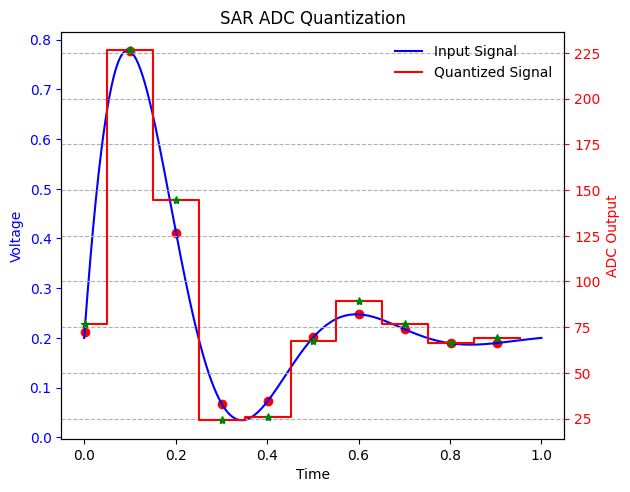

ADC Area: 80
ADC Power: 0.8


In [23]:
# 定义 SAR ADC 参数
resolution = 8  # 分辨率为 8 位
temperature = 0  # 初始温度为 25 度 Celsius
lower_ref_voltage = 0
upper_ref_voltage = 1
digital_sampling_rate = 10  # 采样率为 10 kHz
noise = 2/2**resolution # noise is 2LSB

# 生成输入信号
analog_sampling_rate = 1000  # 信号频率为 1 kHz
x = np.linspace(0, 1, analog_sampling_rate)
input_signal = np.sin(4*np.pi*x)*np.exp(-5*x)+0.2
#input_signal = np.sin(2*np.pi*x*analog_sampling_rate)*0.5+0.5

# 对输入信号进行量化
adc = SAR(resolution, noise, temperature, lower_ref_voltage, upper_ref_voltage)
#adc.forward_fft(input_signal, plot=True)
s = System(analog_sampling_rate=analog_sampling_rate, digital_sampling_rate=digital_sampling_rate, adc=adc)

title = 'SAR ADC Quantization'
v = Visualize_adc()
v.plot(s.get_signal(input_signal), title)

# 估算 SAR ADC 的面积和功耗
adc_area = estimate_area(resolution)
adc_power = estimate_power(resolution)
print("ADC Area:", adc_area)
print("ADC Power:", adc_power)

# ΔΣ ADC

In [11]:
# 1-order Sigma-Delta ADC
class SigmaDeltaADC(object):
    def __init__(self, oversampling_ratio, resolution, lower_ref_voltage, upper_ref_voltage, temperature):
        self.oversampling_ratio = oversampling_ratio
        self.resolution = resolution
        self.lower_ref_voltage = lower_ref_voltage
        self.upper_ref_voltage = upper_ref_voltage
        self.temperature = temperature
        self.integrator = 0
        self.last_output = 0

    def modulator(self, input_signal):
        output = []
        for sample in input_signal:
            # Add input signal to integrator
            self.integrator += sample - self.last_output
            
            # Comparator: output 1 if integrator >= 0, else 0
            if self.integrator >= 0:
                self.last_output = self.upper_ref_voltage
            else:
                self.last_output = self.lower_ref_voltage
            
            output.append(self.last_output)
        return np.array(output)

    def decimator(self, modulated_signal):
        # Simple averaging filter for decimation
        return np.mean(modulated_signal.reshape(-1, self.oversampling_ratio), axis=1)

    def get_val(self, input_signal):
        # Normalize input signal to reference voltage range
        input_signal = input_signal + np.random.normal(scale=0.1 * self.temperature)
        input_signal = np.clip(input_signal, self.lower_ref_voltage, self.upper_ref_voltage)
        normalized_signal = (input_signal - self.lower_ref_voltage) / (self.upper_ref_voltage - self.lower_ref_voltage)
        
        # Modulate input signal
        modulated_signal = self.modulator(normalized_signal)
        
        # Decimate modulated signal
        decimated_signal = self.decimator(modulated_signal)
        
        # Scale to ADC resolution
        adc_values = np.floor(decimated_signal * (2**self.resolution - 1))
        return adc_values

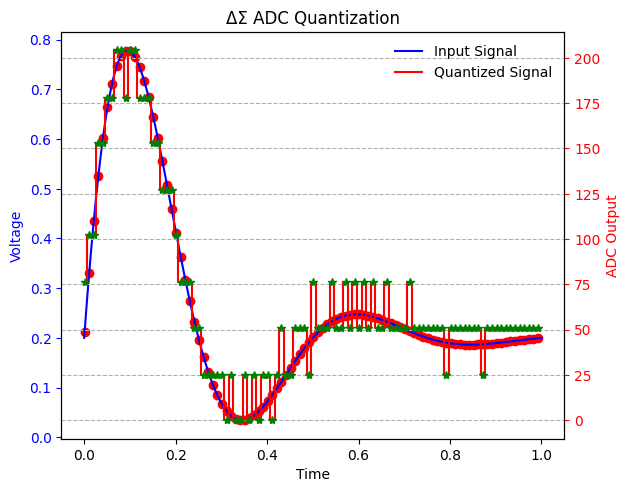

In [12]:
resolution = 8
lower_ref_voltage = 0
upper_ref_voltage = 1
temperature = 0
digital_sampling_rate = 100 # ADC frequency
analog_sampling_rate = 1000
x = np.linspace(0, 1, analog_sampling_rate)
#x = np.sin(4*np.pi*x)*np.exp(-5*x)*6.5+1.1
x = np.sin(4*np.pi*x)*np.exp(-5*x)+0.2

adc = SigmaDeltaADC(oversampling_ratio=10, resolution=resolution, lower_ref_voltage=lower_ref_voltage, upper_ref_voltage=upper_ref_voltage, temperature=temperature)
s = System(analog_sampling_rate=analog_sampling_rate, digital_sampling_rate=digital_sampling_rate, adc=adc)

title = 'ΔΣ ADC Quantization'
v = Visualize_adc()
v.plot(s.get_signal(x), title)   

# Flash ADC

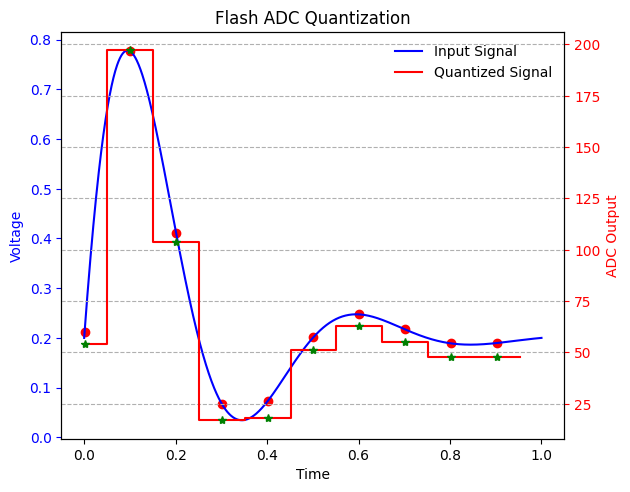

In [65]:
class FlashADC(objectq):
    """This class simulates the function of a Flash ADC"""

    def __init__(self, resolution, lower_ref_voltage, upper_ref_voltage, temperature):
        self.resolution = resolution
        self.lower_ref_voltage = lower_ref_voltage
        self.upper_ref_voltage = upper_ref_voltage
        self.temperature = temperature
        self.num_levels = 2 ** resolution - 1
        self.thresholds = np.linspace(lower_ref_voltage, upper_ref_voltage, self.num_levels + 1)

    def get_val(self, val):
        val = np.clip(val, self.lower_ref_voltage, self.upper_ref_voltage) + np.random.normal(scale=0.1 * self.temperature)
        adc_val = np.digitize(val, self.thresholds) - 1
        return adc_val
    
resolution = 8
lower_ref_voltage = 0
upper_ref_voltage = 1
temperature = 0
digital_sampling_rate = 10 # ADC frequency
analog_sampling_rate = 1000
x = np.linspace(0, 1, analog_sampling_rate)
#x = np.sin(4*np.pi*x)*np.exp(-5*x)*6.5+1.1
x = np.sin(4*np.pi*x)*np.exp(-5*x)+0.2

adc = FlashADC(resolution=resolution, lower_ref_voltage=lower_ref_voltage, upper_ref_voltage=upper_ref_voltage, temperature=temperature)
s = System(analog_sampling_rate=analog_sampling_rate, digital_sampling_rate=digital_sampling_rate, adc=adc)

title = 'Flash ADC Quantization'
v = Visualize_adc()
v.plot(s.get_signal(x), title)   

# Pipeline ADC

In [21]:
class PipelineStage:
    """This class simulates a single stage of the Pipeline ADC"""
    def __init__(self, stage_bits, lower_ref_voltage, upper_ref_voltage):
        self.stage_bits = stage_bits
        self.lower_ref_voltage = lower_ref_voltage
        self.upper_ref_voltage = upper_ref_voltage
        self.thresholds = np.linspace(lower_ref_voltage, upper_ref_voltage, 2 ** stage_bits)
        self.step_size = (upper_ref_voltage - lower_ref_voltage) / (2 ** stage_bits)

    def process(self, input_voltage):
        # Quantize the input
        quantized_value = np.digitize(input_voltage, self.thresholds) - 1
        quantized_voltage = quantized_value * self.step_size + self.lower_ref_voltage
        # Calculate the residue
        residue = input_voltage - quantized_voltage
        return quantized_value, residue

class PipelineADC:
    """This class simulates a Pipeline ADC"""
    def __init__(self, resolution, lower_ref_voltage, upper_ref_voltage, temperature):
        self.resolution = resolution
        self.stages = 1
        self.lower_ref_voltage = lower_ref_voltage
        self.upper_ref_voltage = upper_ref_voltage
        self.temperature = temperature
        self.stage_bits = resolution // self.stages
        self.pipeline_stages = [PipelineStage(self.stage_bits, lower_ref_voltage, upper_ref_voltage) for _ in range(self.stages)]

    def get_val(self, val):
        val = np.clip(val, self.lower_ref_voltage, self.upper_ref_voltage) + np.random.normal(scale=0.1 * self.temperature)
        total_quantized_value = 0
        residue = val

        for stage in self.pipeline_stages:
            quantized_value, residue = stage.process(residue)
            total_quantized_value = (total_quantized_value << self.stage_bits) | quantized_value

        return total_quantized_value

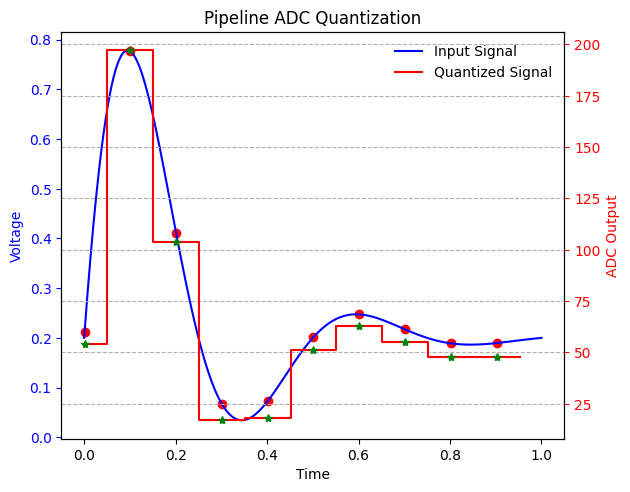

In [22]:
resolution = 8
lower_ref_voltage = 0
upper_ref_voltage = 1
temperature = 0
digital_sampling_rate = 10 # ADC frequency
analog_sampling_rate = 1000
x = np.linspace(0, 1, analog_sampling_rate)
#x = np.sin(4*np.pi*x)*np.exp(-5*x)*6.5+1.1
x = np.sin(4*np.pi*x)*np.exp(-5*x)+0.2

adc = PipelineADC(resolution=resolution, lower_ref_voltage=lower_ref_voltage, upper_ref_voltage=upper_ref_voltage, temperature=temperature)
s = System(analog_sampling_rate=analog_sampling_rate, digital_sampling_rate=digital_sampling_rate, adc=adc)

title = 'Pipeline ADC Quantization'
v = Visualize_adc()
v.plot(s.get_signal(x), title)   

# DSE

In [ ]:
import numpy as np
from scipy.optimize import minimize

# 定义ADC的性能模型
def adc_performance_model(bits, sampling_rate):
    # 模拟功耗、面积和延迟的关系
    power = 0.1 * np.power(2, bits) * sampling_rate
    area = 0.01 * np.power(2, bits)
    latency = 1 / (sampling_rate * np.power(2, bits))
    return power, area, latency

# 目标函数：最小化能耗，同时约束面积和延迟
def objective_function(x):
    bits = x[0] # ADC的位数
    sampling_rate = x[1] # 采样率
    
    # 计算ADC的性能指标
    power, area, latency = adc_performance_model(bits, sampling_rate)
    
    # 设置约束条件：面积和延迟需小于等于给定值
    max_area = 10.0 # 最大允许面积
    max_latency = 0.1 # 最大允许延迟
    
    # 计算约束条件的违反度
    constraint_violation = max(0, area - max_area) + max(0, latency - max_latency)
    
    # 计算目标函数值：能耗
    objective_value = power + 100 * constraint_violation # 使用权重对违反度进行惩罚
    
    return objective_value

# 初始参数
x0 = [8, 10000] # 初始位数和采样率

# 调用优化函数求解最优解
result = minimize(objective_function, x0, method='SLSQP', bounds=[(4, 16), (1000, 20000)])

# 输出最优解
optimal_bits, optimal_sampling_rate = result.x
print("Optimal Number of Bits:", optimal_bits)
print("Optimal Sampling Rate:", optimal_sampling_rate)

# 输出最优解对应的性能指标
optimal_power, optimal_area, optimal_latency = adc_performance_model(optimal_bits, optimal_sampling_rate)
print("Optimal Power:", optimal_power)
print("Optimal Area:", optimal_area)
print("Optimal Latency:", optimal_latency)


Optimal Number of Bits: 4.0
Optimal Sampling Rate: 1000.0000000028467
Optimal Power: 1600.0000000045547
Optimal Area: 0.16
Optimal Latency: 6.249999999982208e-05
